# Тестовое задание. Быков Александр

__Задача__ - предсказать выплатит ли клиент кредит или нет (кредитный скоринг)<br>
Постройте модель и выведите её характеристики (в качестве метрики качества используйте `gini = 2rocauc -1`), обоснуйте используемую архитектуру, переменные и их обработку.

<p><font size="3" face="Arial" font-size="large">
<ul type="square"><li><a href="#1">EDA</a><ul></ul></li><li><a href="#2">Preprocessing</a><li><a href="#3">Обучение</a></li><li><a href="#4">Выводы и предложения</a></li></font></p>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.interpolate import interp1d
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, precision_score

## EDA

<p id="1">Посмотрим на данные и сделаем первые выводы.</p>

In [2]:
df = pd.read_csv("text_data_model (1).csv", error_bad_lines=False, sep=";")
df.head(3)

/Users/flaymax/miniforge3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


,id,dt,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,y
0,7ED6CC5B-6628-4873-9D4C-33455B29CC4C,17.02.2022,"37,0047912",24000.0,Android,Driver license ID,*******ynordemaala1985@gmail.com,NaN,True,True,True,True,"[{""id"": ""E115"", ""name"": ""Domain is a free prov...",0
1,8723B2AB-DFF3-462B-8E9A-34AE3EDA5ECE,17.02.2022,"27,2854209",16000.0,Android,Driver license ID,*******celino47@gmail.com,NaN,False,True,True,False,"[{""id"": ""E115"", ""name"": ""Domain is a free prov...",0
2,9ECAB15D-EE55-4DBA-AEC9-B0E1D81C6F10,18.02.2022,"27,118412",25000.0,Android,TIN,*******lalcaide40@gmail.com,NaN,False,True,True,True,"[{""id"": ""E115"", ""name"": ""Domain is a free prov...",1


In [3]:
df.shape

(2000, 14)

Имеем 13 признаков и 1 бинарный таргет, задача бинарной классификации. Видим пропуски, придется работать с ними.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      2000 non-null   object 
 1   dt      2000 non-null   object 
 2   x1      2000 non-null   object 
 3   x2      1976 non-null   float64
 4   x3      1987 non-null   object 
 5   x4      2000 non-null   object 
 6   x5      2000 non-null   object 
 7   x6      34 non-null     object 
 8   x7      1953 non-null   object 
 9   x8      1943 non-null   object 
 10  x9      1982 non-null   object 
 11  x10     1943 non-null   object 
 12  x11     2000 non-null   object 
 13  y       2000 non-null   int64  
dtypes: float64(1), int64(1), object(12)
memory usage: 218.9+ KB


`x1` стоит перевести во `float`

In [5]:
df["x1"]

0       37,0047912
1       27,2854209
2        27,118412
3       31,4223134
4       35,4086242
           ...    
1995    36,9089664
1996    31,4168377
1997    36,1779603
1998    40,5913757
1999    29,6755646
Name: x1, Length: 2000, dtype: object

Это очень похоже на возраст человека. 

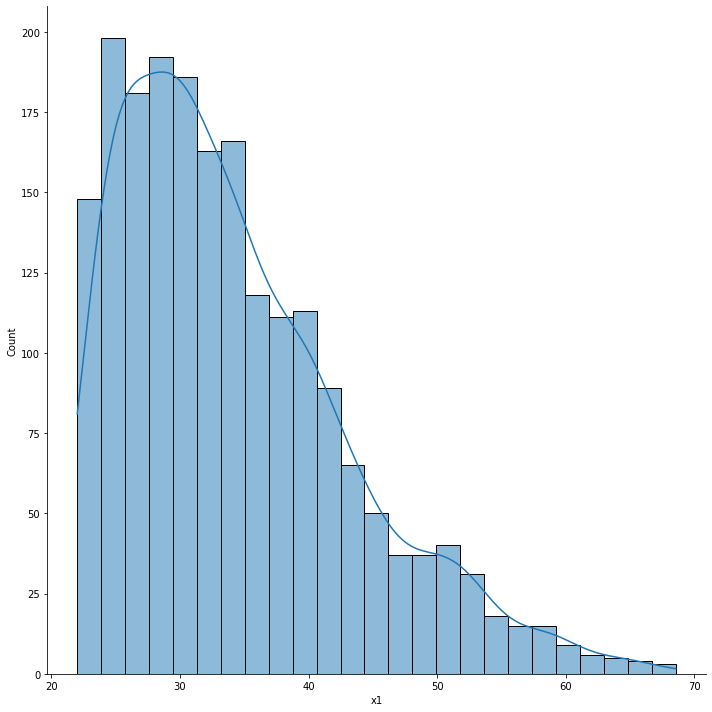

In [6]:
df["x1"] = df["x1"].apply(lambda x: float(x.replace(",", ".")))
sns.displot(df["x1"], height=10, kde=True)

`x2` скорее всего какая-то сумма в деньгах.

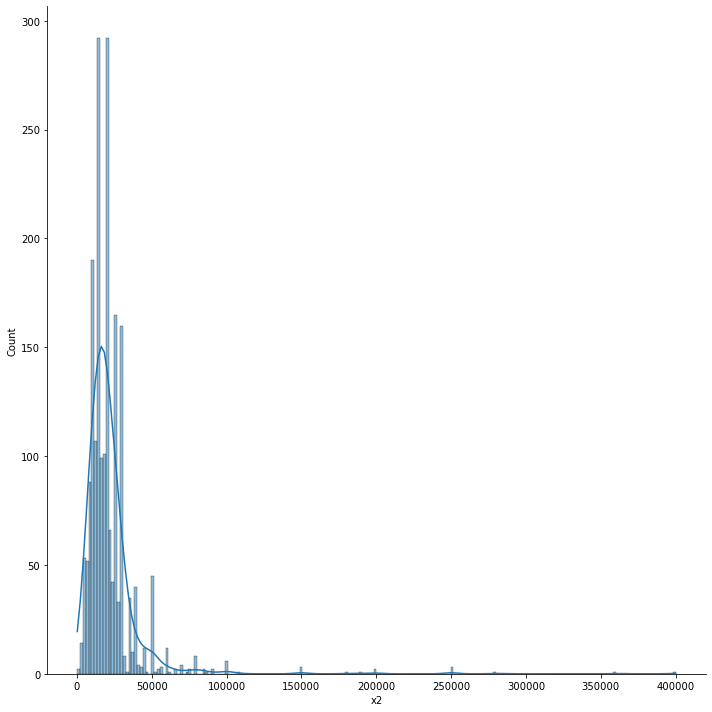

In [7]:
sns.displot(df, x=df["x2"], height=10, kde=True)

`x3` представляет платформу. Видно доминирование Android.

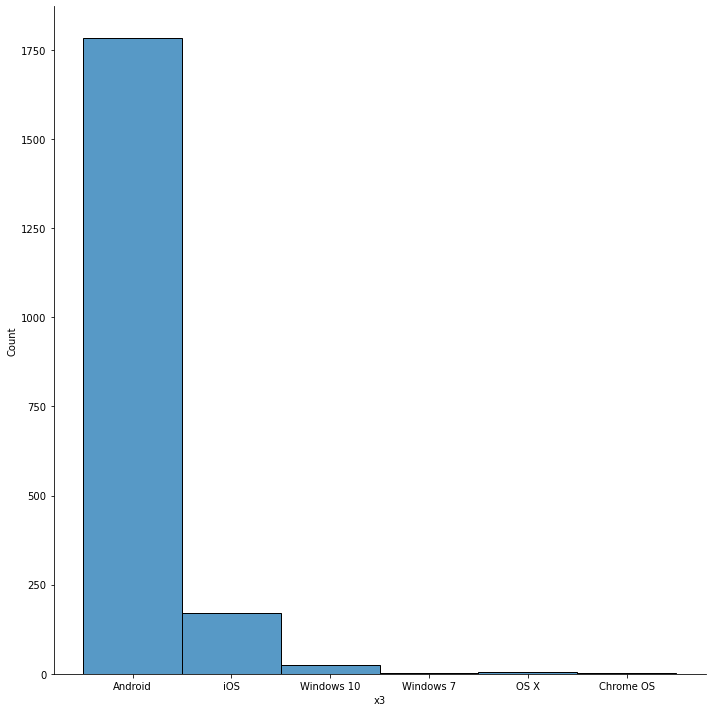

In [8]:
sns.displot(df, x=df["x3"], height=10)

`x4` судя по всему вид ID документа.

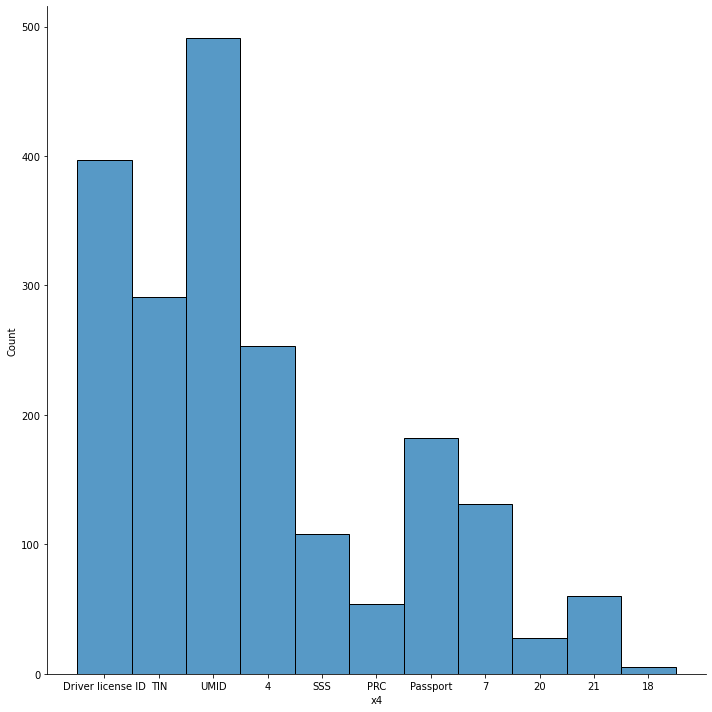

In [9]:
sns.displot(df, x=df["x4"], height=10)

В данных есть бинарные признаки `x7 - x10`. В них стоит заполнить пропуски.

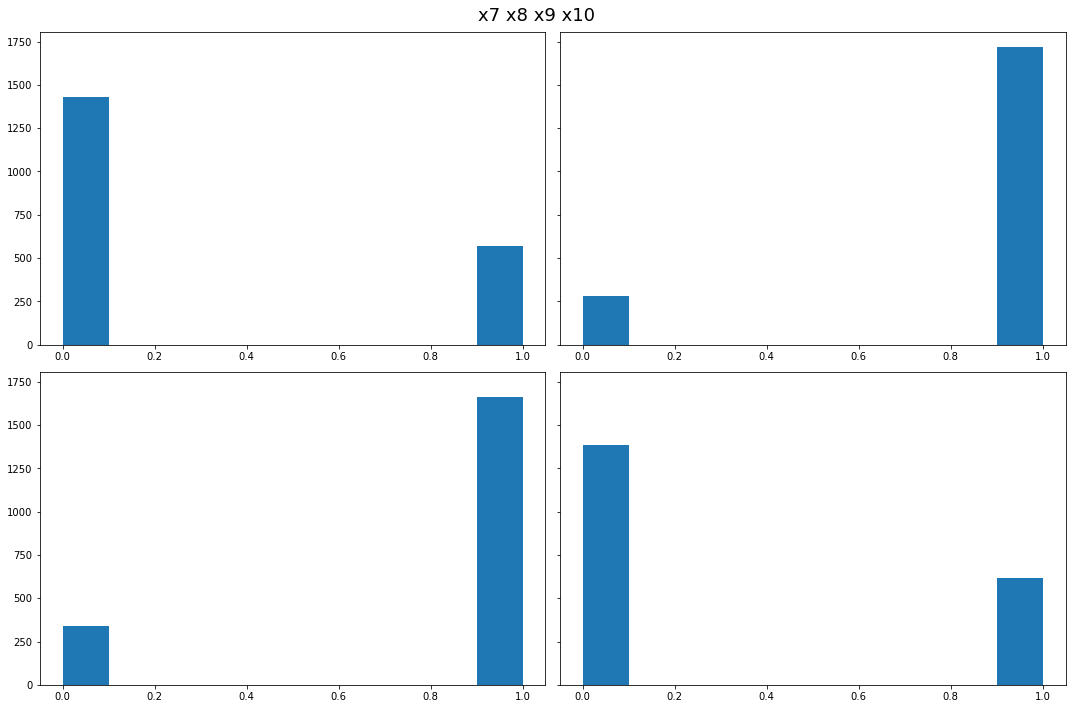

In [10]:
df['x7'].replace({True:1,False:0},inplace=True)
df['x8'].replace({True:1,False:0},inplace=True)
df['x9'].replace({True:1,False:0},inplace=True)
df['x10'].replace({True:1,False:0},inplace=True)
df['x7'].fillna(np.random.choice([0,1]), inplace=True)
df['x8'].fillna(np.random.choice([0,1]), inplace=True)
df['x9'].fillna(np.random.choice([0,1]), inplace=True)
df['x10'].fillna(np.random.choice([0,1]), inplace=True)


fig, axs = plt.subplots(nrows=2,ncols=2, sharey=True, tight_layout=True, figsize=(15, 10))
fig.suptitle("x7 x8 x9 x10",fontsize = 18)

axs[0][0].hist(df['x7'])
axs[0][1].hist(df['x8'])
axs[1][0].hist(df['x9'])
axs[1][1].hist(df['x10'])
plt.show()

Остальные признаки: 

- `dt` - некая дата (возможно стоит извлечь месяц, но не понятно как нам поможет это в будущем)
- `x5` - email (можно извлечь только вид домена) 
- `x6` - номер телефона (очень мало сэмплов где он есть) 
- `x11` - словари с некими данными, которые предстоит распарсить

In [11]:
df["dt"].sample(2)

70      17.02.2022
1663    09.01.2022
Name: dt, dtype: object

In [12]:
df["dt"].value_counts()

18.02.2022    596
09.01.2022    539
17.02.2022    401
19.02.2022    251
08.01.2022     77
10.01.2022     68
12.02.2022     49
20.02.2022     15
14.02.2022      3
13.01.2022      1
Name: dt, dtype: int64

In [13]:
df["x5"].sample(2)

1199    *******amontescarlett@gmail.com
625         *******gieocampo7@gmail.com
Name: x5, dtype: object

In [14]:
df["x6"].sample(2)

1770    NaN
1590    NaN
Name: x6, dtype: object

In [16]:
df["x6"].unique()

array([nan, '+6390627*****', '+6396311*****', '+6393959*****',
       '+6391724*****', '+6399827*****', '+6397009*****', '+6393052*****',
       '+6397746*****', '+6393928*****', '+6394653*****', '+6399177*****',
       '+63 912 *****', '+6393541*****', '+6391900*****', '+6399824*****',
       '+6390669*****', '+6394800*****', '+6395686*****', '+6390797*****',
       '+6392951*****', '+6391762*****', '+6390566*****', '+6393080*****',
       '+6399146*****', '+6390955*****', '+6391571*****', '+6391639*****',
       '+6394586*****', '+6397777*****', '+6390913*****', '+6391780*****',
       '+6391827*****', '+6396667*****', '+6395166*****'], dtype=object)

In [17]:
df["x11"].sample(2)

1270    [{"id": "E115", "name": "Domain is a free prov...
92      [{"id": "E115", "name": "Domain is a free prov...
Name: x11, dtype: object

Еще посмотрим на признаки относительно таргета.

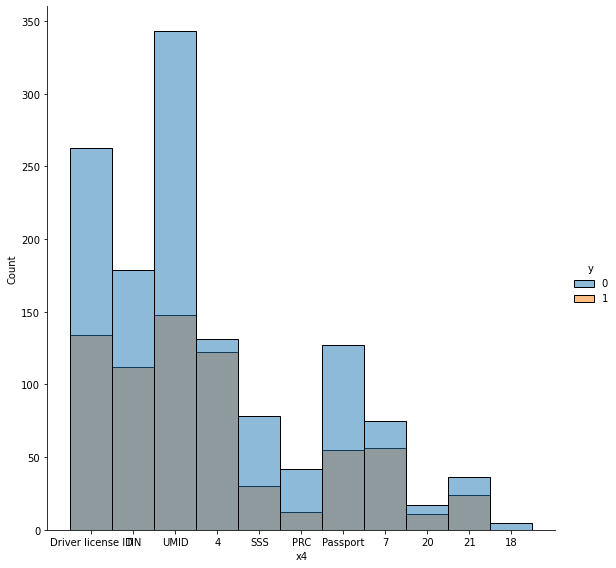

In [18]:
sns.displot(df, x='x4', hue='y', height=8)

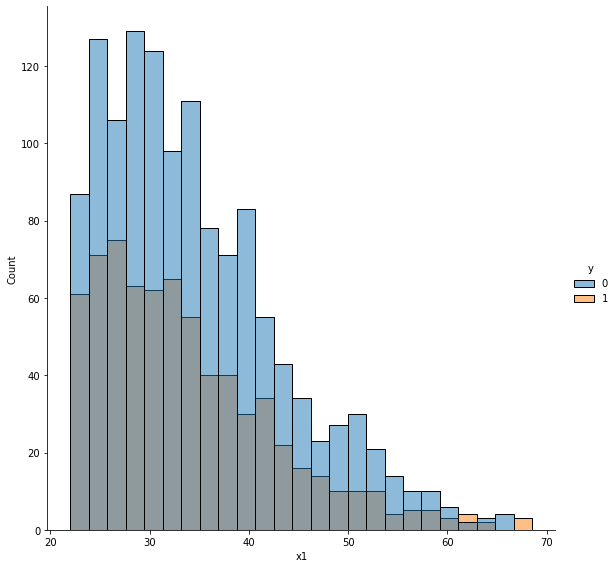

In [19]:
sns.displot(df, x='x1', hue='y', height=8)

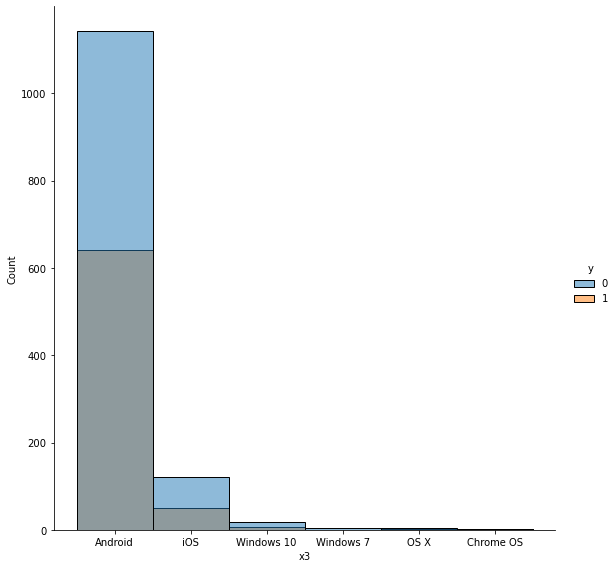

In [20]:
sns.displot(df, x='x3', hue='y', height=8)

Предварительно сделаем one-hot encoding используемой ОС, ID, домена email и отметим бинарно наличие телефона. Посмотрим на `pairplot` с таргетом, на корреляцию Пирсона. 

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      2000 non-null   object 
 1   dt      2000 non-null   object 
 2   x1      2000 non-null   float64
 3   x2      1976 non-null   float64
 4   x3      1987 non-null   object 
 5   x4      2000 non-null   object 
 6   x5      2000 non-null   object 
 7   x6      34 non-null     object 
 8   x7      2000 non-null   float64
 9   x8      2000 non-null   float64
 10  x9      2000 non-null   float64
 11  x10     2000 non-null   float64
 12  x11     2000 non-null   object 
 13  y       2000 non-null   int64  
dtypes: float64(6), int64(1), object(7)
memory usage: 218.9+ KB


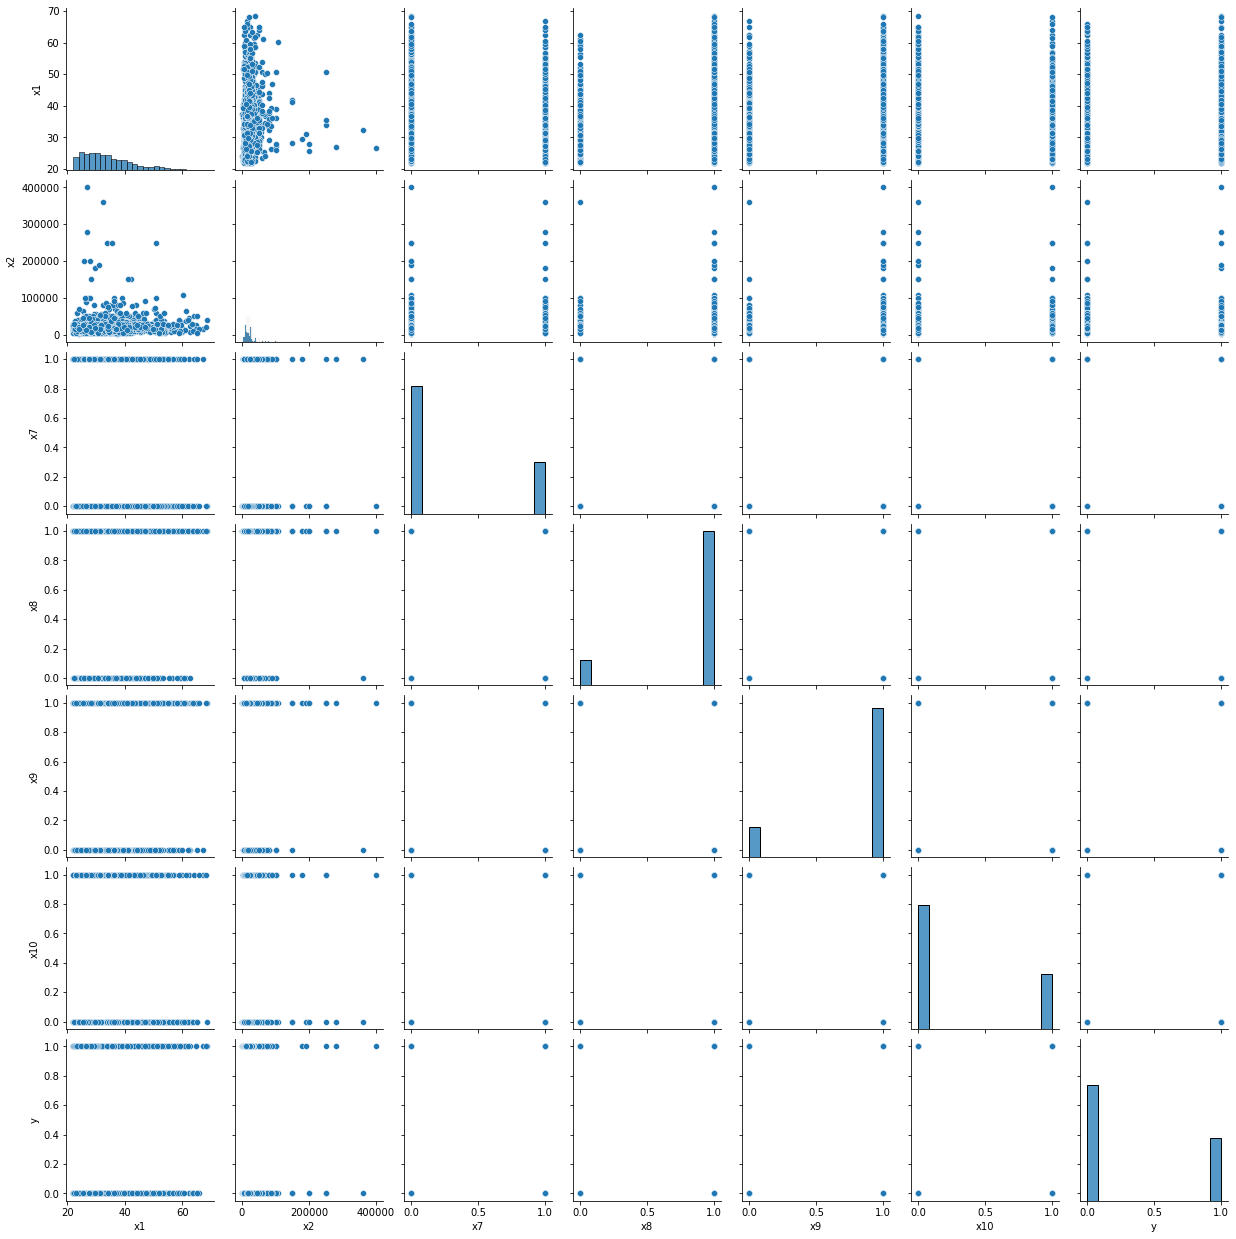

In [22]:
sns.pairplot(df[["x1", "x2", "x3", "x4", "x7", "x8", "x9", "x10", "y"]])

In [23]:
# x5 - возьмем домен почты и сделаем ohe
df["x5"] = df["x5"].apply(lambda x: x.split("@")[1])
df = pd.get_dummies(data=df, columns=['x5'])
# x3 - заполним пропуски и сделаем ohe
df['x3'].fillna(np.random.choice(df["x3"].unique().tolist()), inplace=True)
df = pd.get_dummies(data=df, columns=['x3'])
# x4
df = pd.get_dummies(data=df, columns=['x4'])
# x6 - заполним наличие телефона 0 или 1 
# (возможно есть смысл распарсить из интернета вид оператора по коду оператора, но сэмплов c наличием тлф очень мало)
df['x6'].fillna(0, inplace=True)
def func(x):
    if isinstance(x, str):
        return 1
    else:
        return x
df['x6']=df['x6'].apply(func)

Единственная внятная корреляция с таргетом есть у признака `x4_4`.

<AxesSubplot:>

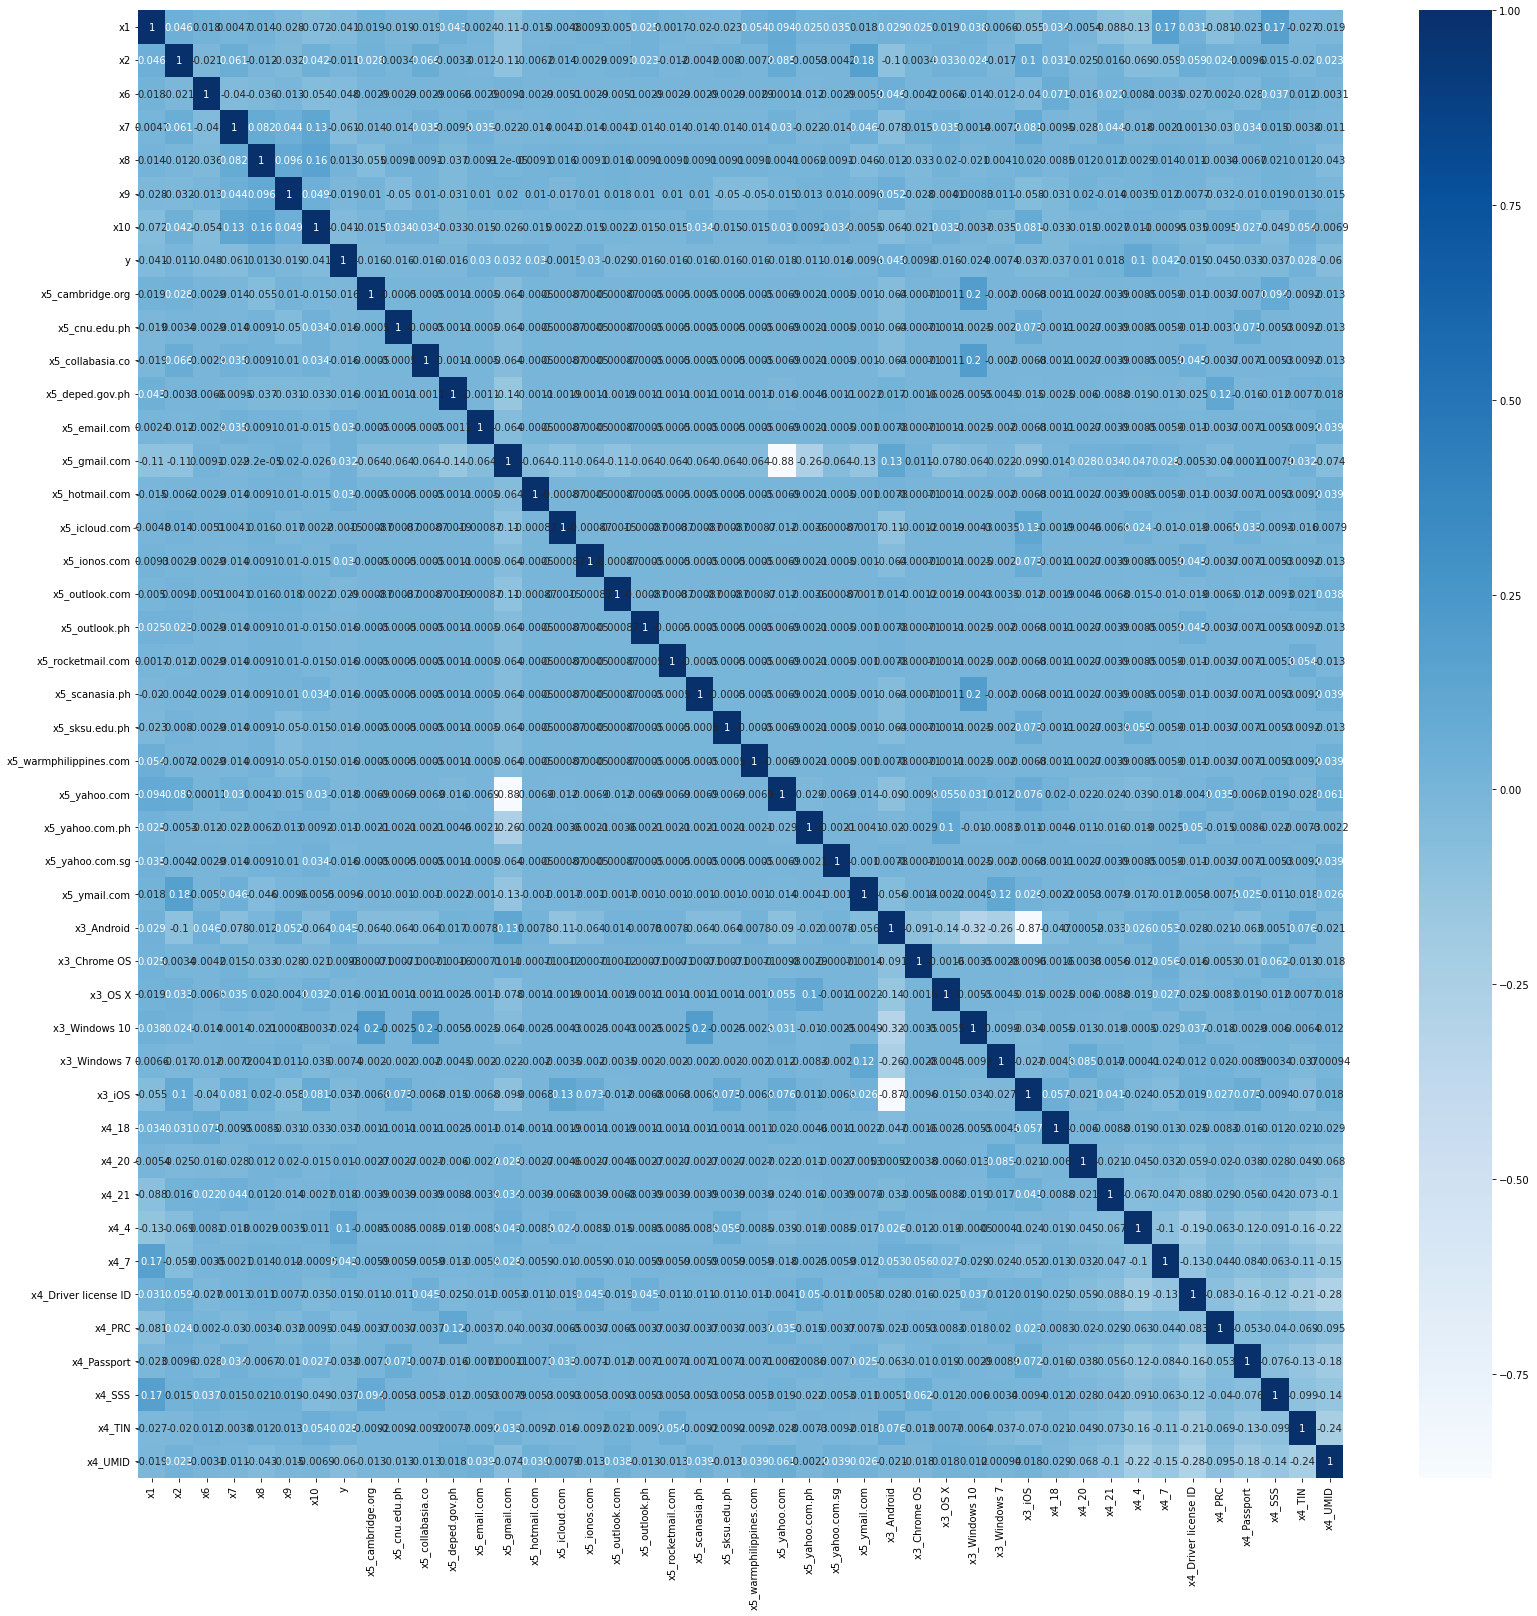

In [24]:
corr = corr = df.corr()

fig, ax = plt.subplots(figsize=(27,27))         
sb.heatmap(corr, cmap="Blues", annot=True)

__Выводы:__ данных мало, будем работать с тем, что есть и парсить `x11`. 

## Preprocessing

<p id="2">Соберем все вместе.</p>

In [25]:
df = pd.read_csv("text_data_model (1).csv", error_bad_lines=False, sep=";")
df["x1"] = df["x1"].apply(lambda x: float(x.replace(",", ".")))
df["x5"] = df["x5"].apply(lambda x: x.split("@")[1])
df = pd.get_dummies(data=df, columns=['x5'])
df['x7'].replace({True:1,False:0},inplace=True)
df['x8'].replace({True:1,False:0},inplace=True)
df['x9'].replace({True:1,False:0},inplace=True)
df['x10'].replace({True:1,False:0},inplace=True)
df['x2'].fillna(np.random.choice([18500+i*100 for i in range(16)]), inplace=True)
df['x3'].fillna(np.random.choice(df["x3"].unique().tolist()), inplace=True)
df['x7'].fillna(np.random.choice([0,1]), inplace=True)
df['x8'].fillna(np.random.choice([0,1]), inplace=True)
df['x9'].fillna(np.random.choice([0,1]), inplace=True)
df['x10'].fillna(np.random.choice([0,1]), inplace=True)
df = pd.get_dummies(data=df, columns=['x3'])
df = pd.get_dummies(data=df, columns=['x4'])
df.drop(["id", "dt", "x6"], axis=1, inplace=True)

/Users/flaymax/miniforge3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


Посмотрим на то что есть в `x11`.

In [26]:
df["x11"] = df["x11"].apply(lambda x: eval(x))
df["x11"].loc[0]

[{'id': 'E115',
  'name': 'Domain is a free provider. At least 2 online profiles were found. It was not involved in a data breach',
  'score': 1.0,
  'operation': '+'},
 {'id': 'PH100',
  'name': 'At least 2 online profiles were found',
  'score': 0.0,
  'operation': '+'}]

Соберем ключи.

In [27]:
sc = set()
ids_all = []
scores_all = []
names_all = []
operations = []
idss=[]

for item in df["x11"]:
    ids = [i["id"] for i in item]
    scores = [i["score"] for i in item] 
    names = [i["name"] for i in item]
    operation = [i["operation"] for i in item]
    ids_all.append(ids)
    scores_all.append(scores)
    names_all.append(names)
    operations.append(operation)
    for id_ in ids:
        idss.append(id_)

In [28]:
np.unique(np.array(idss))

array(['E101', 'E107', 'E108', 'E109', 'E111', 'E112', 'E113', 'E114',
       'E115', 'E117', 'E124', 'E125', 'E126', 'E127', 'HC100', 'HC101',
       'HC113', 'HC114', 'HC118', 'HC119', 'HC123', 'HC125', 'P100',
       'P101', 'P102', 'P106', 'P107', 'P108', 'P109', 'P110', 'P111',
       'P112', 'PH100', 'PH101', 'PH102'], dtype='<U5')

In [29]:
np.unique(np.array(operation))

array(['+'], dtype='<U1')

Возьмем `id` и `score` в качестве фичей.

In [30]:
un_ids = np.unique(np.array(idss))
di = dict(zip(un_ids, [[] for i in range(len(un_ids))]))
for item, i in zip(df["x11"], range(len(df["x11"]))):
    for dicts in item:
        di[dicts["id"]]+=[float(dicts["score"])+1]
    for key in di.keys():
        while len(di[key])!=i+1:
            di[key]+=[0]

In [31]:
for key, value in zip(di.keys(), di.values()):
    df[key] = value

In [32]:
sc = []
for item in df["x11"]:
    flag = False
    score = sum([i["score"] for i in item])
    sc.append(score)
df["score"] = sc

In [33]:
scf = []
for item in df["x11"]:
    flag = False
    for i in range(len(item)):
        if "blacklist" in item[i]["name"]:
            scf.append(1)
            flag=True
            continue
    if flag:
        continue
    scf.append(0)
df["blacklist"] = scf

In [34]:
df.sample(2)

,x1,x2,x7,x8,x9,x10,x11,y,x5_cambridge.org,x5_cnu.edu.ph,...,P108,P109,P110,P111,P112,PH100,PH101,PH102,score,blacklist
1522,27.652293,13000.0,0.0,1.0,1.0,1.0,"[{'id': 'E111', 'name': 'Domain is a free prov...",1,0,0,...,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,10.0,1
313,27.225188,20000.0,1.0,1.0,1.0,0.0,"[{'id': 'E115', 'name': 'Domain is a free prov...",0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0


<AxesSubplot:>

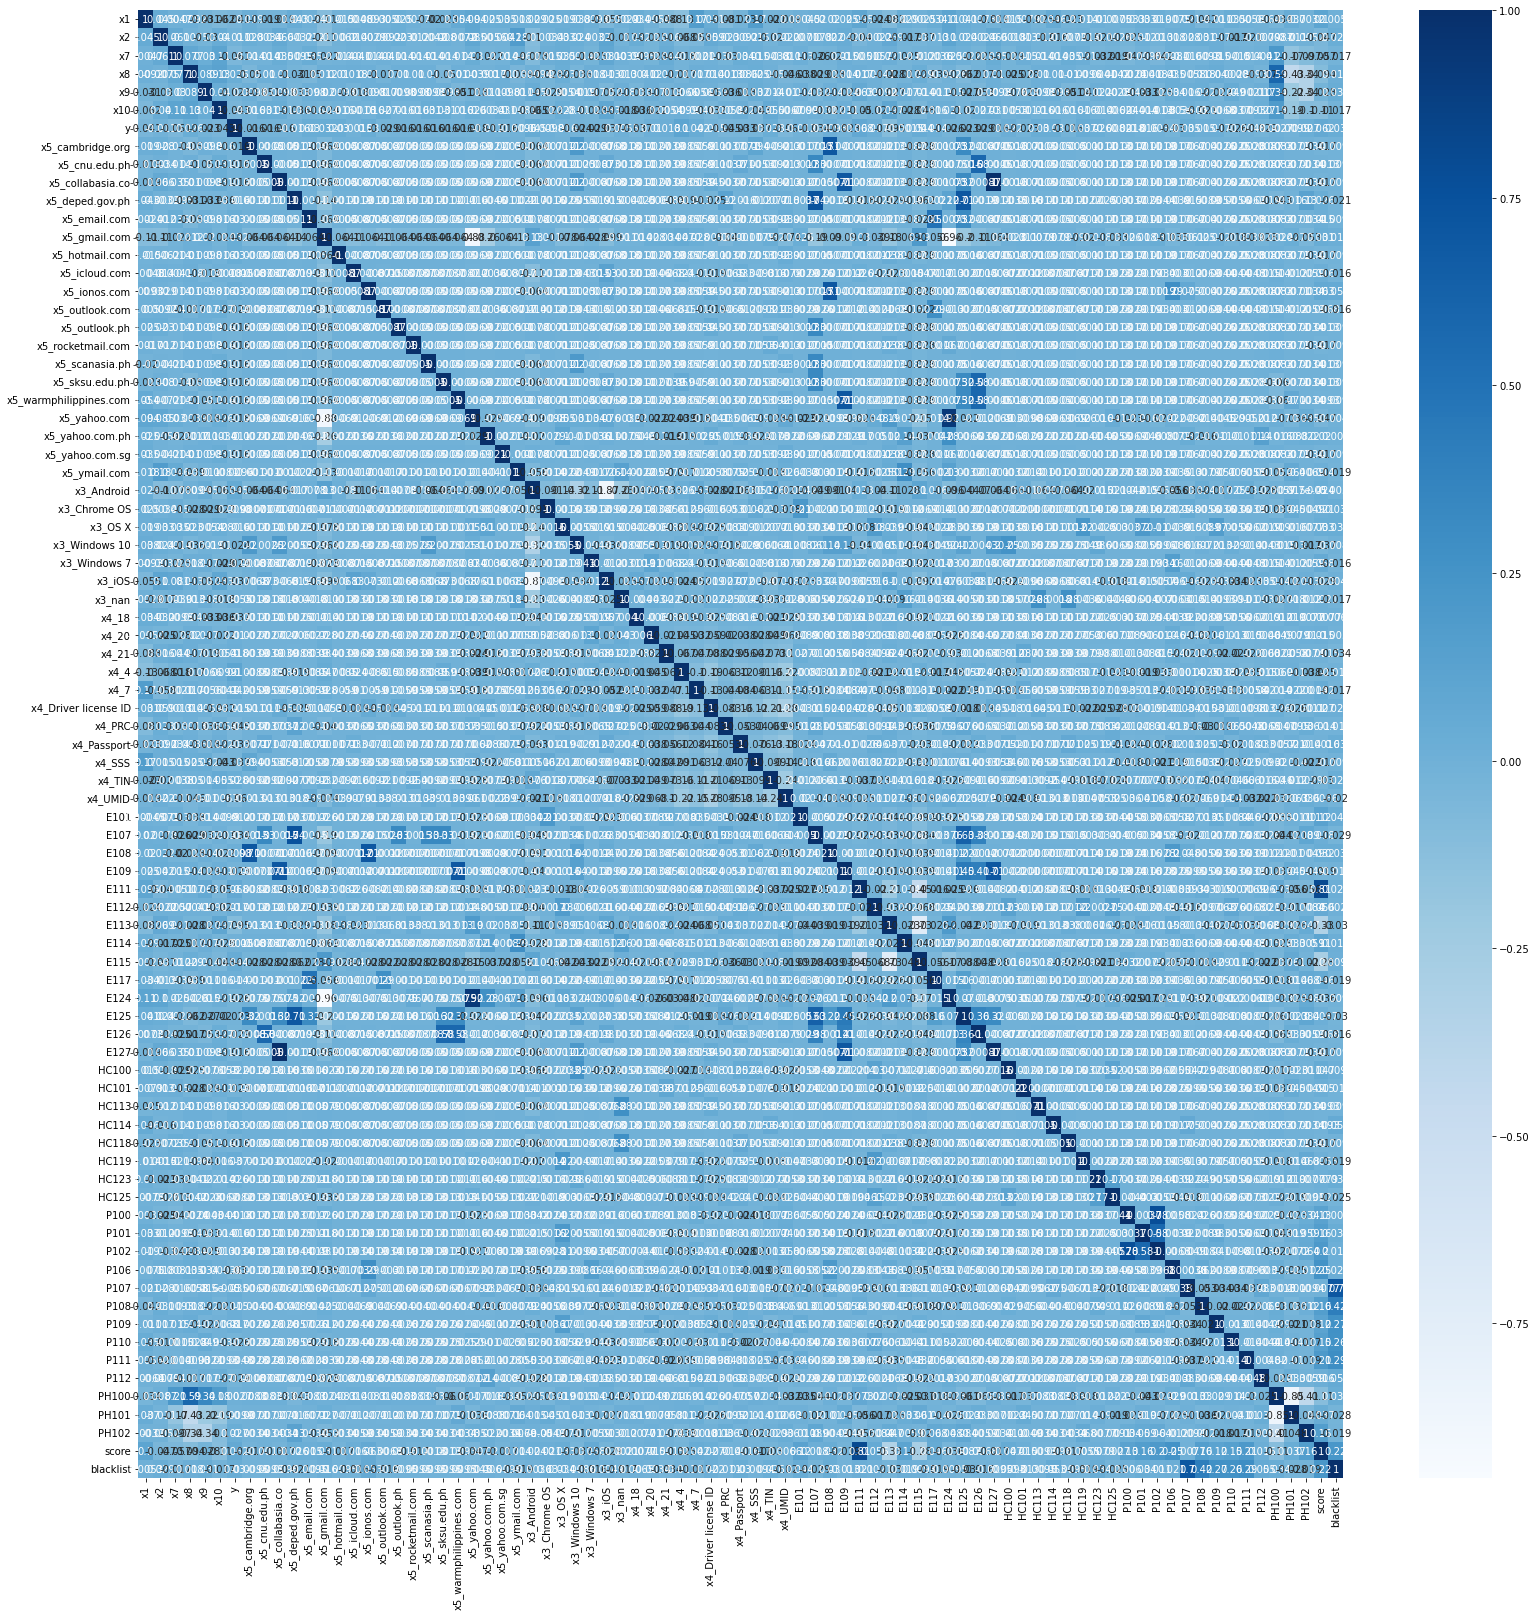

In [35]:
df.drop("x11", axis=1, inplace=True)
corr = corr = df.corr()

fig, ax = plt.subplots(figsize=(27,27))         
sb.heatmap(corr, cmap="Blues", annot=True)

## Обучение

<p id="3"></p>

In [36]:
target = "y"
y = df[target]
df.drop(target, axis=1, inplace=True)

Используем `SelectKBest` для отбора фичей.

In [37]:
new_df = SelectKBest(f_classif, k=11).fit_transform(df, y)
new_df

/Users/flaymax/miniforge3/lib/python3.9/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'str_']. An error will be raised in 1.2.
  warnings.warn(
/Users/flaymax/miniforge3/lib/python3.9/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'str_']. An error will be raised in 1.2.
  warnings.warn(


array([[1., 1., 1., ..., 0., 2., 1.],
       [0., 0., 1., ..., 0., 2., 1.],
       [0., 1., 1., ..., 0., 2., 1.],
       ...,
       [1., 0., 1., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 2., 1.],
       [0., 0., 1., ..., 0., 2., 2.]])

In [38]:
y.value_counts()

0    1296
1     704
Name: y, dtype: int64

Классы неравномерные, используем `SMOTE` (synthetic minority over-sampling technique) для балансировки классов. 

https://www.jair.org/index.php/jair/article/view/10302

Критерий AUC-ROC устойчив к несбалансированным классам (но на практике увы, не всё так однозначно) и может быть интерпретирован как вероятность того, что случайно выбранный positive объект будет проранжирован классификатором выше (будет иметь более высокую вероятность быть positive), чем случайно выбранный negative объект. 

Сочетание метода избыточной выборки меньшего класса и недостаточной выборки большего класса может обеспечить лучшую эффеткивность классификатора (по ROC-AUC), чем просто недостаточная выборка мажоритарного класса. Часто `SMOTE` использовали на соревах.

Также нормируем данные.

In [39]:
X_train, X_test, y_train, y_test = train_test_split(
    new_df, y, test_size=0.2, random_state=42)
sm = SMOTE(k_neighbors=5, random_state=42)

X_res, y_res = sm.fit_resample(X_train, y_train)
scaler = MinMaxScaler()
X_res = scaler.fit_transform(X_res)


In [40]:
y_res.value_counts()

0    1039
1    1039
Name: y, dtype: int64

Обучимся на разных сидах и усредним, часто дает больше устойчивости и небольшой буст в скоре, исходя из опыта соревок.

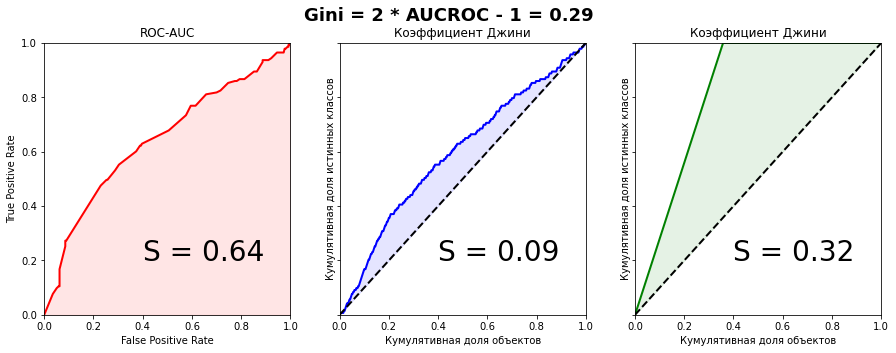

In [42]:
preds = []

for i in range(150):
    
    clf = LogisticRegression(random_state=i)
    clf.fit(X_res, y_res)
    X_test= scaler.transform(X_test)
    preds_prob = clf.predict_proba(X_test)[:, 1]
    preds.append(preds_prob)
preds_test = np.zeros(len(preds[0]))

for model_p in preds:
    preds_test+=model_p
preds_1 = preds_test/len(preds)

actual = y_test
predict = preds_1


aucroc = roc_auc_score(actual, predict)
gini = 2*roc_auc_score(actual, predict)-1
fpr, tpr, t = roc_curve(actual, predict)

data = zip(actual, predict)
sorted_data = sorted(data, key=lambda d: d[1], reverse=True)
sorted_actual = [d[0] for d in sorted_data]
cumulative_actual = np.cumsum(sorted_actual) / sum(actual)
cumulative_index = np.arange(1, len(cumulative_actual)+1) / len(predict)
cumulative_actual_perfect = np.cumsum(sorted(actual, reverse=True)) / sum(actual)

x_values = [0] + list(cumulative_index)
y_values = [0] + list(cumulative_actual)
y_values_perfect = [0] + list(cumulative_actual_perfect)
f1, f2 = interp1d(x_values, y_values), interp1d(x_values, y_values_perfect)
S_pred = quad(f1, 0, 1, points=x_values, limit=10000)[0] - 0.5
S_actual = quad(f2, 0, 1, points=x_values, limit=10000)[0] - 0.5



fig, ax = plt.subplots(nrows=1,ncols=3, sharey=True, figsize=(15, 5))
fig.suptitle('Gini = 2 * AUCROC - 1 = {:0.2f}\n\n'.format(gini),fontsize = 18, fontweight='bold')
ax[0].plot([0]+fpr.tolist(), [0]+tpr.tolist(), lw = 2, color = 'red')
ax[0].fill_between([0]+fpr.tolist(), [0]+tpr.tolist(), color = 'red', alpha=0.1)
ax[0].text(0.4,0.2,'S = {:0.2f}'.format(aucroc),fontsize = 28)
ax[1].plot(x_values, y_values, lw = 2, color = 'blue')
ax[1].fill_between(x_values, x_values, y_values, color = 'blue', alpha=0.1)
ax[1].text(0.4,0.2,'S = {:0.2f}'.format(S_pred),fontsize = 28)
ax[2].plot(x_values, y_values_perfect, lw = 2, color = 'green')
ax[2].fill_between(x_values, x_values, y_values_perfect, color = 'green', alpha=0.1)
ax[2].text(0.4,0.2,'S = {:0.2f}'.format(S_actual),fontsize = 28)

ax[0].set(title='ROC-AUC', xlabel='False Positive Rate', 
              ylabel='True Positive Rate', xlim=(0, 1), ylim=(0, 1))
for i in range(1,3):
    ax[i].plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
    ax[i].set(title='Коэффициент Джини', xlabel='Кумулятивная доля объектов', 
              ylabel='Кумулятивная доля истинных классов', xlim=(0, 1), ylim=(0, 1))
plt.show();

### Выводы и предложения

<p id="4">Пробовал обучать бустинги и деревья, но логистическая регрессия как ни странно показала себя лучше всех. Дальше еще много чего можно сделать для улучшения модели, но конечная цель этого задания вероятно не в большом скоре из-за малого кол-ва данных. </p>

Можно еще сделать для поднятия скора:

- тюнинг гиперпараметров optuna или gridsearch
- кросс-валидация repeated kfold
- попытки фиче генерации
- попытаться использовать псевдолэйблинг (часто помогает на соревнованиях)
- попробовать tabnet
- побить количественные фичи на бакеты по какой-либо логике

И, конечно, для понимания таких задач нужна более глубокая вовлеченность в процесс, понимание фичей и нахождение в среде. 